&copy;  C. Lázaro, Universidad Politécnica de Valencia, 2015

# Form finding of planar flexible rods (7)

Refinement of 2DRodFF_6

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
import scipy.special as sp
import scipy.optimize

## 1 Form-finding tool for a single rod

In [3]:
def omegaDeltaomega(muA, muB, flag, k):
    if (abs(muA)<1E-8 and abs(muB)<1E-8):
        omega_0 = -.5*np.pi
        Deltaomega_0 = np.pi
    else:
        if (muA >= 0):
            omega_0 = np.arccos(np.pi*muA/2./k)                                  # OK
            Deltaomega_0 = np.arccos(np.pi*muB/2./k) - omega_0                   # OK
            omega_1 = -np.arccos(np.pi*muA/2./k)                                 # OK
            Deltaomega_1 = np.arccos(np.pi*muB/2./k) - omega_1                   # OK
        else:
            omega_1 = np.arccos(np.pi*muA/2./k) - 2*np.pi
            omega_0 = -np.arccos(np.pi*muA/2./k)                                 # OK
            if (muB >= 0):
                Deltaomega_1 = -np.arccos(np.pi*muB/2./k) - omega_1
                Deltaomega_0 = -np.arccos(np.pi*muB/2./k) - omega_0              # OK
            else:
                Deltaomega_1 = -np.arccos(np.pi*muB/2./k) - omega_1
                Deltaomega_0 = -np.arccos(np.pi*muB/2./k) - omega_0              # OK
        
    if (flag == 0):
        #print('omega_0 = {0:.5f},    Deltaomega_0 = {1:.5f}'.format(omega_0, Deltaomega_0))
        return(omega_0, Deltaomega_0)
    else:
        #print('omega_1 = {0:.5f},    Deltaomega_1 = {1:.5f}'.format(omega_1, Deltaomega_1))
        return(omega_1, Deltaomega_1)
    

In [4]:
def lmbdk(muA, muB, flag, k):
    wA, Deltaw = omegaDeltaomega(muA, muB, flag, k)
    Deltaxi = (2*(sp.ellipeinc(wA+Deltaw,k**2) - sp.ellipeinc(wA,k**2)) - (sp.ellipkinc(wA+Deltaw,k**2) - sp.ellipkinc(wA,k**2)))/np.pi
    Deltaeta = -2*k*(np.cos(wA+Deltaw) - np.cos(wA))/np.pi
    lmbd = np.sqrt(Deltaxi**2 + Deltaeta**2)
    return(lmbd)

In [5]:
class F:
    def __init__(self, muA, muB, lmbdAB, flag):
        self.muA = muA
        self.muB = muB
        self.lmbdAB = lmbdAB
        self.flag = flag
        
    def __call__(self, k):
        lmbd = lmbdk(self.muA, self.muB, self.flag, k)
        return(self.lmbdAB - lmbd)

In [6]:
class Elastica:
    def __init__(self, gammaA=None, gammaB=None, R=None, MA=None, MB=None, EI=None):
        self.gammaA = gammaA
        self.gammaB = gammaB
        self.beta = np.angle(gammaB - gammaA)
        
        self.R = R
        self.MA = MA
        self.MB = MB
        self.EI = EI
        
        self.dAB = np.absolute(gammaB - gammaA)        # Distance between rod end-sections
        self.S = (MA - MB)/self.dAB                    # Shear force S (perpendicular to R)
        self.P = - np.sqrt(R**2 + self.S**2)           # Invariant compressive force
        self.lcrit = np.pi*np.sqrt(EI/abs(self.P))     # Critical length
        
        self.lmbdAB = self.dAB/self.lcrit              # Normalized distance
        self.muA = MA/abs(self.P)/self.lcrit           # Adimensional moments
        self.muB = MB/abs(self.P)/self.lcrit
        
        self.flag = 0
        
        self.k = None                                  # k parameter, to be computed
        self.HmodP = None                              # H/|P| = -cos(theta_0)
        
        self.alpha = None
        self.phiA = None
        self.phiB = None
    
    def data(self):
        print(' dAB = {0:8.4f}         lcrit = {1:8.4f} m'.format(self.dAB, self.lcrit))
        print('   R = {0:8.4f} kN          S = {1:8.4f} kN'.format(self.R, self.S))
        #print('   P = {0:8.4f} kN'.format(self.P))
        #print('lambdaAB = {1:8.4f}'.format(self.lcrit, self.lmbdAB))
        print('  MA = {0:8.4f}            MB = {1:8.4f}'.format(self.MA, self.MB))
        print(' muA = {0:8.4f}           muB = {1:8.4f}'.format(self.muA, self.muB))
    
    def compute_k(self):
        muA = self.muA
        muB = self.muB
        lmbdAB = self.lmbdAB
        flag = self.flag
        
        if (abs(muA)<1E-8 and abs(muB)< 1E-8):
            kmin = 0.
        else:
            kmin = max(np.pi*abs(muA)/2., np.pi*abs(muB)/2.) # Lowest possible value for k
        print('kmin = {0:.5f}'.format(kmin))
        
        rng_k = np.arange(kmin, 1., 0.05)
        rng_f = []
        flag = 0
        print('flag = {}'.format(flag))
        i = 0
        for k in rng_k:
            # print(i)
            lmbd = lmbdk(muA, muB, flag, k)
            f = lmbdAB - lmbd
            rng_f.append(f)
            # print('k = {0:.5f},    lmbd = {1:.5f},    f = {2:.5f},'.format(k, lmbd, f))
            i += 1
        rng_signf = np.sign(np.asarray(rng_f))
        rng_index = rng_signf[:-1] + rng_signf[1:]
        rng_index = rng_index.tolist()
        #print(rng_index)
        
        if 0. in rng_index:
            index00 = rng_index.index(0.)
            index01 = len(rng_index) - (rng_index[::-1]).index(0.) - 1
            #print(index00, index01)
        else:
            rng_f = []
            flag = 1
            print('flag = {}'.format(flag))
            i = 0
            for k in rng_k:
                #print(i)
                lmbd = lmbdk(muA, muB, flag, k)
                f = lmbdAB - lmbd
                rng_f.append(f)
                print('k = {0:.5f},    lmbd = {1:.5f},    f = {2:.5f},'.format(k, lmbd, f))
                i += 1
            rng_signf = np.sign(np.asarray(rng_f))
            rng_index = rng_signf[:-1] + rng_signf[1:]
            rng_index = rng_index.tolist()
            #print(rng_index)
            
            index00 = rng_index.index(0.)
            index01 = len(rng_index) - (rng_index[::-1]).index(0.) - 1
            #print(index00, index01)        
                
        HmodP00 = -np.cos(2*np.arcsin(rng_k[index00]))
        HmodP01 = -np.cos(2*np.arcsin(rng_k[index01]))
        #print('H/|P|00 = {0:.5f},    H/|P|01 = {1:.5f}'.format(HmodP00, HmodP01))
        if (index00==index01):
            index0 = index00
        else:
            if (HmodP00<=HmodP01):
                index0 = index00
            else:
                index0 = index01
        #print(index0)
        
        ka = rng_k[index0]
        kb = rng_k[index0+1]
        #print('ka = {0:.5f},    kb = {1:.5f}'.format(ka, kb))
        
        f = F(muA, muB, lmbdAB, flag)
        self.k = scipy.optimize.brentq(f, ka, kb)    # Solve for k
        self.HmodP = -np.cos(2*np.arcsin(self.k))
        self.flag = flag
        print('k = {0:.5f},    H/|P| = {1:.5f}'.format(self.k, self.HmodP))
        print
        
    def compute_Config(self):
        gammaA = self.gammaA
        beta = self.beta
        muA = self.muA
        muB = self.muB
        lcrit = self.lcrit
        flag = self.flag
        try:
            k = float(self.k)
        except ValueError:
            raise ValueError('Method .compute_k has to be executed first')
                    
        nVertex = 101
        (wA, Deltaw) = omegaDeltaomega(muA, muB, flag, k)
        if Deltaw<0:
            wA = -wA
            Deltaw = -Deltaw
        rng_w = np.linspace(wA, wA+Deltaw, nVertex)
        
        rng_zeta = []
        rng_xi = []
        rng_eta = []
        for w in rng_w:
            zeta = (sp.ellipkinc(w,k**2) + sp.ellipk(k**2))/np.pi
            xi = 2*(sp.ellipeinc(w,k**2) + sp.ellipe(k**2))/np.pi - zeta
            eta = -2*k*np.cos(w)/np.pi
            rng_zeta.append(zeta)
            rng_xi.append(xi)
            rng_eta.append(eta)
        rng_xi = np.asarray(rng_xi)
        rng_eta = np.asarray(rng_eta)

        alpha = np.arctan2(rng_eta[-1]-rng_eta[0], rng_xi[-1]-rng_xi[0])
        print('beta = {0:.5f}    alpha = {1:.5f}'.format(beta, alpha))
        rng_x = gammaA.real + np.cos(beta - alpha)*lcrit*(rng_xi - rng_xi[0]) - np.sin(beta - alpha)*lcrit*(rng_eta - rng_eta[0])
        rng_y = gammaA.imag + np.sin(beta - alpha)*lcrit*(rng_xi - rng_xi[0]) + np.cos(beta - alpha)*lcrit*(rng_eta - rng_eta[0])
        
        phiA = 2*np.arcsin(k*np.sin(wA)) + beta - alpha
        phiB = 2*np.arcsin(k*np.sin(wA + Deltaw)) + beta - alpha
        print('phiA = {0:.5f}    phiB = {1:.5f}'.format(phiA, phiB))
        
        self.alpha = alpha
        self.phiA = phiA
        self.phiB = phiB
        
        #return(rng_xi, rng_eta)
        return(rng_x, rng_y)
    
    def plot(self):
        fig = plt.figure(figsize=(9,9))
        ax = fig.gca(aspect='equal')
        
        (x, y) = self.compute_Config()
        ax.plot(x, y, color ='b')
        ax.grid()
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        

In [7]:
test_element = Elastica(gammaA=complex(0.0, 0.0), gammaB=complex(5.2318, 0.), R=-26.1588, MA=-16.2602, MB=-84.6883, EI=500.)

In [8]:
test_element.data()

 dAB =   5.2318         lcrit =  12.9897 m
   R = -26.1588 kN          S =  13.0793 kN
  MA = -16.2602            MB = -84.6883
 muA =  -0.0428           muB =  -0.2229


In [9]:
test_element.compute_k()

kmin = 0.35016
flag = 0
k = 0.35323,    H/|P| = -0.75045



beta = 0.00000    alpha = 0.46364
phiA = 0.24462    phiB = -0.37069


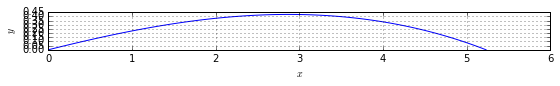

In [10]:
test_element.plot()

## 2 Complex force densities

The 2D formfinding equations in complex form are

$$\mathbf{D}_l = \mathbf{C}_l^{\mathsf{T}} \,\mathbf{P}\,\mathbf{C}_l$$
$$\mathbf{D}_f = \mathbf{C}_l^{\mathsf{T}} \,\mathbf{P}\,\mathbf{C}_f $$
$$\mathbf{\gamma}_l = \mathbf{D}_l^{-1} \bigl( \mathbf{\phi}_l - \mathbf{D}_f \,\mathbf{\gamma}_f \bigr)$$

Where the diagonal elements of the force density matrix are the complex force densities
$$q_{IJ} = r_{IJ} + i \,s_{IJ}$$
$r_{IJ} = R_{IJ}/d_{IJ}$ is the tension (compression) tension density and $s_{IJ} = S_{IJ}/d_{IJ}$ the transverse force density.  
$\mathbf{C}_l$, $\mathbf{C}_f$ are the connectivity matrixes.

In [11]:
class StructuralElement:
    def __init__(self, startNode, endNode, complexq):
        self.startNode = startNode
        self.endNode = endNode
        self.complexq = complexq
        
        self.gammaA = None
        self.gammaB = None
        self.dAB = None
        self.R = None
        self.S = None
        self.DeltaM = None
        self.MA = None
        self.MB = None
        
        self.EI = 500.
        
    def setActiveParams(self, gammaA, gammaB):
        self.gammaA = gammaA
        self.gammaB = gammaB
        self.dAB = np.absolute(gammaB - gammaA)
        
        self.R = self.complexq.real*self.dAB
        self.S = self.complexq.imag*self.dAB
        self.DeltaM = - self.S*self.dAB
        
    def setEndMoments(self, node, M):
        try:
            DeltaM = float(self.DeltaM)
        except ValueError:
            raise ValueError('Method .setActiveParams has to be executed first')
            
        if node=='start':
            self.MA = M
            self.MB = self.MA + self.DeltaM
        else:
            self.MB = M
            self.MA = self.MB - self.DeltaM

In [135]:
# Input data

# Total number of nodes
NN = 6    

# Nodes
indexFreeNode = [1, 2]
indexFixedNode = [0, 3, 4, 5]
gammaF = np.array([
complex(-5.0, 0.),
complex(5.0, 0.),
complex(0., 5.0),   
complex(0., -5.0)
])
NF = len(gammaF)                                # Number of fixed nodes
print('Fixed nodes')
print(gammaF)
print

# Structural Members
NABR = 1                                        # Number of active bending rods
rng_activeBendingRod = [None]*NABR
# Active Members
rng_activeBendingRod[0] = []
rng_activeBendingRod[0].append(StructuralElement(0, 1, complex(-5.,  4.7895)))
rng_activeBendingRod[0].append(StructuralElement(1, 2, complex(-7.5, -6.6428)))
rng_activeBendingRod[0].append(StructuralElement(2, 3, complex(-5.,  4.7895)))
# Tension members
rng_axialMember = []
rng_axialMember.append(StructuralElement(1, 4, 7.5))
rng_axialMember.append(StructuralElement(2, 5, 7.5))

# Number of members
MMA = 0
for activeBendingRod in rng_activeBendingRod:
    MMA += len(activeBendingRod)                 # Bending active members
MMT = len(rng_axialMember)                       # Tension active members
MM = MMA + MMT

# Connectivity matrix
C = np.zeros((MM, NN))
i = 0
for activeBendingRod in rng_activeBendingRod:
    for activeElement in activeBendingRod:
        C[i, activeElement.startNode] = 1
        C[i, activeElement.endNode] = -1
        i += 1
for axialMember in rng_axialMember:
    C[i, axialMember.startNode] = 1
    C[i, axialMember.endNode] = -1
    i += 1

CL = C[:, indexFreeNode]
CF = C[:, indexFixedNode]
print('Connectivity matrix')
print(CL)
print(CF)
print

# Force densities in kN/m corresponding to every element
q = []
for activeBendingRod in rng_activeBendingRod:
    for activeElement in activeBendingRod:
        q.append(activeElement.complexq)
for axialMember in rng_axialMember:
    q.append(axialMember.complexq)

qQ = np.diagflat(q)
print('Complex force densities')
print(qQ)
print

# External forces
fL = np.array([
complex(0., 0.),
complex(0., 0.)
])
print('External forces')
print(fL)
print

Fixed nodes
[-5.+0.j  5.+0.j  0.+5.j  0.-5.j]

Connectivity matrix
[[-1.  0.]
 [ 1. -1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

Complex force densities
[[-5.0+4.7895j  0.0+0.j      0.0+0.j      0.0+0.j      0.0+0.j    ]
 [ 0.0+0.j     -7.5-6.6428j  0.0+0.j      0.0+0.j      0.0+0.j    ]
 [ 0.0+0.j      0.0+0.j     -5.0+4.7895j  0.0+0.j      0.0+0.j    ]
 [ 0.0+0.j      0.0+0.j      0.0+0.j      7.5+0.j      0.0+0.j    ]
 [ 0.0+0.j      0.0+0.j      0.0+0.j      0.0+0.j      7.5+0.j    ]]

External forces
[ 0.+0.j  0.+0.j]



In [136]:
# Solution of the force density equations

gammaL = np.zeros(NN - NF)
DL = np.zeros((NN - NF, NN - NF))
DF = np.zeros((NN - NF, NF))

DL = np.dot(np.transpose(CL), np.dot(qQ, CL))
DF = np.dot(np.transpose(CL), np.dot(qQ, CF))

gammaL = np.linalg.solve(DL, fL - np.dot(DF, gammaF))
print('Free node coordinates')
print(gammaL)
print

Free node coordinates
[-1.87206777+0.188222j  1.87206777-0.188222j]



In [137]:
rng_gamma = np.empty(len(indexFreeNode)+len(indexFixedNode), dtype=complex)
rng_gamma[indexFreeNode] = gammaL
rng_gamma[indexFixedNode] = gammaF
print(rng_gamma)

[-5.00000000+0.j       -1.87206777+0.188222j  1.87206777-0.188222j
  5.00000000+0.j        0.00000000+5.j        0.00000000-5.j      ]


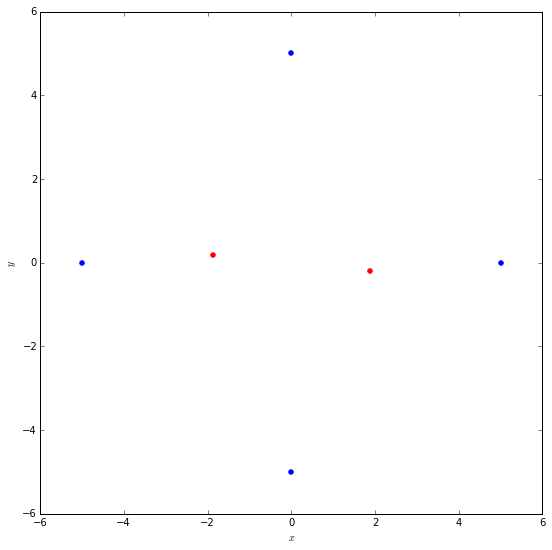

In [138]:
fig = plt.figure(figsize=(9,9))

ax = fig.gca(aspect='equal')
ax.scatter(gammaF.real, gammaF.imag, color='b')
ax.scatter(gammaL.real, gammaL.imag, color='r')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

## 3 Structural form-finding (1)

In [139]:
totalDeltaM = [0.]*NABR
i = 0
for activeBendingRod in rng_activeBendingRod:
    for activeElement in activeBendingRod:
        startNode = activeElement.startNode
        endNode = activeElement.endNode
        activeElement.setActiveParams(rng_gamma[startNode], rng_gamma[endNode])
        totalDeltaM[i] += activeElement.DeltaM
    i += 1

In [140]:
for i in range(NABR):
    print('Total DeltaM = {:.5f}'.format(totalDeltaM[i]))

Total DeltaM = 0.00387


In [141]:
stateM = [-0.5*M for M in totalDeltaM]
#stateM = [0]
i = 0                         # Hay que revisar el código para el caso en que los nodos no sean correlativos
for activeBendingRod in rng_activeBendingRod:
    for activeElement in activeBendingRod:
        activeElement.setEndMoments('start', stateM[i])
        stateM[i] = activeElement.MB
    i += 1        

In [142]:
for activeBendingRod in rng_activeBendingRod:
    for activeElement in activeBendingRod:
        print(activeElement.MA, activeElement.MB)        

(-0.0019340606818829542, -47.031890833445075)
(-47.031890833445075, 47.031890833445075)
(47.031890833445075, 0.0019340606818829542)


In [143]:
rng_elastica = [None]*NABR
i = 0
for activeBendingRod in rng_activeBendingRod:
    rng_elastica[i] = []
    for activeElement in activeBendingRod:
        startNode = activeElement.startNode
        endNode = activeElement.endNode
        R = activeElement.R
        MA = activeElement.MA
        MB = activeElement.MB
        EI = activeElement.EI
        rng_elastica[i].append(Elastica(rng_gamma[startNode], rng_gamma[endNode], R, MA, MB, EI))
    i += 1

In [144]:
i = 0
for elasticaRod in rng_elastica:
    j = 0
    print('Elastica Rod {}'.format(i))
    print('***************')
    for element in elasticaRod:
        print('Element {}'.format(j))
        element.data()
        element.compute_k()
        j += 1
    print
    i += 1

Elastica Rod 0
***************
Element 0
 dAB =   3.1336         lcrit =  15.0814 m
   R = -15.6680 kN          S =  15.0083 kN
  MA =  -0.0019            MB = -47.0319
 muA =  -0.0000           muB =  -0.1437
kmin = 0.22578
flag = 0
k = 0.39627,    H/|P| = -0.68594

Element 1
 dAB =   3.7630         lcrit =  11.4409 m
   R = -28.2226 kN          S = -24.9969 kN
  MA = -47.0319            MB =  47.0319
 muA =  -0.1090           muB =   0.1090
kmin = 0.17128
flag = 0
k = 0.36863,    H/|P| = -0.72822

Element 2
 dAB =   3.1336         lcrit =  15.0814 m
   R = -15.6680 kN          S =  15.0083 kN
  MA =  47.0319            MB =   0.0019
 muA =   0.1437           muB =   0.0000
kmin = 0.22578
flag = 0
k = 0.39627,    H/|P| = -0.68594




beta = 0.06010    alpha = 0.76390
phiA = 0.11111    phiB = -0.04037
beta = -0.10021    alpha = -0.72486
phiA = -0.04038    phiB = -0.04038
beta = 0.06010    alpha = 0.76390
phiA = -0.04037    phiB = 0.11111


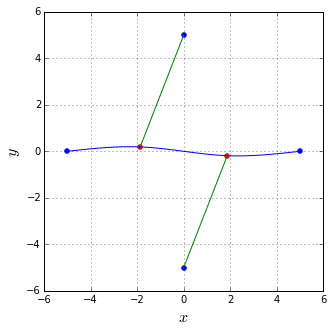

In [145]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca(aspect='equal')
font = {'size'   : 16}

ax.scatter(gammaF.real, gammaF.imag, color='b')
ax.scatter(gammaL.real, gammaL.imag, color='r')

for elasticaRod in rng_elastica:
    for element in elasticaRod:
        (x, y) = element.compute_Config()
        ax.plot(x, y, color ='b')

for axialMember in rng_axialMember:
    startNode = axialMember.startNode
    endNode = axialMember.endNode
    complexq = axialMember.complexq
    if abs(complexq) > 1E-8:
        x = rng_gamma[[startNode, endNode]].real
        y = rng_gamma[[startNode, endNode]].imag
        if complexq > 0:
            ax.plot(x, y, color ='g')
        else:
            ax.plot(x, y, color ='r')

ax.grid()
ax.set_xlabel(r'$x$', fontdict=font)
ax.set_ylabel(r'$y$', fontdict=font)
        


In [147]:
i = 0
for elasticaRod in rng_elastica:
    for element in elasticaRod:
        print('phi{0}A = {1:.5f}    phi{2}B = {3:.5f}'.format(i, element.phiA, i, element.phiB))

phi0A = 0.11111    phi0B = -0.04037
phi0A = -0.04038    phi0B = -0.04038
phi0A = -0.04037    phi0B = 0.11111


In [148]:
print(totalDeltaM)

[0.0038681213637659084]


## 4 Structural form-finding (2)

In [149]:
def setForceDensityMat(rng_activeBendingRod):
    q = []
    for activeBendingRod in rng_activeBendingRod:
        for activeElement in activeBendingRod:
            q.append(activeElement.complexq)
    for axialMember in rng_axialMember:
        q.append(axialMember.complexq)

    qQ = np.diagflat(q)
    #print('Complex force density matrix')
    #print(qQ)
    #print
    return(qQ)
    

In [150]:
def computeGamma(indexFreeNode, indexFixedNode, gammaF, CL, CF, qQ):
    NL = len(indexFreeNode)
    NF = len(indexFixedNode)
    
    DL = np.zeros((NL, NL))
    DF = np.zeros((NL, NF))
    gammaL = np.zeros(NL)
    
    DL = np.dot(np.transpose(CL), np.dot(qQ, CL))
    DF = np.dot(np.transpose(CL), np.dot(qQ, CF))
    gammaL = np.linalg.solve(DL, fL - np.dot(DF, gammaF))
    
    rng_gamma = np.empty(len(indexFreeNode)+len(indexFixedNode), dtype=complex)
    rng_gamma[indexFreeNode] = gammaL
    rng_gamma[indexFixedNode] = gammaF
    
    return(gammaL, rng_gamma)

In [258]:
class G:
    def __init__(self, indexFreeNode, indexFixedNode, gammaF, CL, CF, rng_activeBendingRod):
        self.indexFreeNode = indexFreeNode
        self.indexFixedNode = indexFixedNode
        self.gammaF = gammaF
        self.gammaL = None
        self.rng_gamma = None
        self.CL = CL
        self.CF = CF
        self.rng_activeBendingRod = rng_activeBendingRod
        self.rng_elastica = None
                
    def __call__(self, x):        
        indexFreeNode = self.indexFreeNode 
        indexFixedNode = self.indexFixedNode 
        gammaF = self.gammaF 
        CL = self.CL 
        CF = self.CF
        rng_activeBendingRod = self.rng_activeBendingRod
        NABR = len(rng_activeBendingRod)
        
        # Update shear densities in each element
        i = 0
        for activeBendingRod in rng_activeBendingRod:
            v = x[i]
            #v = np.insert(v, 0, activeBendingRod[0].complexq.imag)
            NELS = len(activeBendingRod)
            v = np.append(v, activeBendingRod[NELS-1].complexq.imag)
            print('v = {}'.format(v))
            k = 0
            for activeElement in activeBendingRod:
                complexq = activeElement.complexq
                #if k==1:
                #    complexq = complexq.real + 1j*v[0]
                #activeElement.complexq = complexq
                activeElement.complexq = complexq.real + 1j*v[k]
                print(activeElement.complexq)
                k += 1
            i += 1
        
        # Compute new nodal coordinates
        qQ = setForceDensityMat(rng_activeBendingRod)
        (gammaL, rng_gamma) = computeGamma(indexFreeNode, indexFixedNode, gammaF, CL, CF, qQ)
        self.gammaL = gammaL
        self.rng_gamma = rng_gamma
        
        # Compute R, S, DeltaM 
        rng_totalDeltaM = []
        rng_stateM = []
        i = 0
        for activeBendingRod in rng_activeBendingRod:
            totalDeltaM = 0.
            for activeElement in activeBendingRod:
                startNode = activeElement.startNode            
                endNode = activeElement.endNode
                activeElement.setActiveParams(rng_gamma[startNode], rng_gamma[endNode])
                totalDeltaM += activeElement.DeltaM            # Compute Sum DeltaM
                  
            rng_totalDeltaM.append(totalDeltaM)
            i += 1
        
        # Compute start M
        i = 0
        rng_elastica = [None]*NABR
        for activeBendingRod in rng_activeBendingRod:
            rng_elastica[i] = []
            stateM = 0.                                        # Set M at the start node
            #stateM = -0.5*rng_totalDeltaM[i]                   
            for activeElement in activeBendingRod:
                startNode = activeElement.startNode
                endNode = activeElement.endNode
                activeElement.setActiveParams(rng_gamma[startNode], rng_gamma[endNode])
                                                                            
                activeElement.setEndMoments('start', stateM)   # Compute element end moments
                stateM = activeElement.MB
                                                
                R = activeElement.R                            # Define elastica elements from parameters
                MA = activeElement.MA
                MB = activeElement.MB
                EI = activeElement.EI
                rng_elastica[i].append(Elastica(rng_gamma[startNode], rng_gamma[endNode], R, MA, MB, EI))
                
            rng_stateM.append(stateM)
            i += 1
        self.rng_activeBendingRod = rng_activeBendingRod
        
        # Compute k and configuration of elastica elems.
        rng_diffRotation = []*NABR
        i = 0
        for elasticaRod in rng_elastica:
            j = 0
            print('Elastica Rod {}'.format(i))
            print('***************')
            sttRotation = []
            endRotation = []
            for element in elasticaRod:                    
                print('Element {}'.format(j))
                element.data()
                element.compute_k()
                element.compute_Config()
                sttRotation.append(element.phiA)
                endRotation.append(element.phiB)
                j += 1
            print
            
            sttRotation = np.array(sttRotation)            # Compute nodal rotation differences
            endRotation = np.array(endRotation)
            print(sttRotation)
            print(endRotation)
            diffRotation = np.empty(len(elasticaRod)-1)
            diffRotation[:] = endRotation[:-1] - sttRotation[1:]
            #phiStart = 0.
            #diffRotation = np.append(phiStart - sttRotation[0], diffRotation)
            #diffRotation = np.append(phiStart - sttRotation[0], diffRotation[0])
            rng_diffRotation.append(diffRotation)
            i += 1
        self.rng_elastica = rng_elastica
        
        # Define and compute residuals for root search
        rng_residual = []                                  
        for i in range(NABR):
            #totalDeltaM = rng_totalDeltaM[i]
            #stateM = rng_stateM[i]
            diffRotation = rng_diffRotation[i]
            residual = diffRotation
            #residual = diffRotation[0]
            #residual = np.hstack((totalDeltaM, diffRotation))
            rng_residual.append(residual)
        
        rng_residual = np.array(rng_residual).flatten()
        print(x, rng_residual)
        print
        return(rng_residual)
    
    def plot(self):
        gammaF = self.gammaF
        gammaL = self.gammaL
        rng_gamma = self.rng_gamma
        rng_activeBendingRod = self.rng_activeBendingRod
        rng_elastica = self.rng_elastica
        
        fig = plt.figure(figsize=(9,9))
        ax = fig.gca(aspect='equal')
        ax.set_ylim(-4., 8.)
        ax.scatter(gammaF.real, gammaF.imag, color='b')
        ax.scatter(gammaL.real, gammaL.imag, color='r')

        for elasticaRod in rng_elastica:
            for element in elasticaRod:
                (x, y) = element.compute_Config()
                ax.plot(x, y, color ='b')

        for axialMember in rng_axialMember:
            startNode = axialMember.startNode
            endNode = axialMember.endNode
            complexq = axialMember.complexq
            if abs(complexq) > 1E-8:
                x = rng_gamma[[startNode, endNode]].real
                y = rng_gamma[[startNode, endNode]].imag
                if complexq > 0:
                    ax.plot(x, y, color ='g')
                else:
                    ax.plot(x, y, color ='r')

        ax.grid()
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        return

In [259]:
# Input data

# Nodes
indexFreeNode = [1, 2, 3]
indexFixedNode = [0, 4, 5]
gammaF = np.array([
complex( 0. , 0. ),
complex(25. , 1.5),
complex(-1.5, 7.5)
])
print('Fixed nodes')
print(gammaF)
print

# Structural Members
NABR = 1                                        # Number of active bending rods
rng_activeBendingRod = [None]*NABR
# Active Members
rng_activeBendingRod[0] = []
rng_activeBendingRod[0].append(StructuralElement(0, 1, complex(-2.5, 0.5)))
rng_activeBendingRod[0].append(StructuralElement(1, 2, complex(-2.0, 0.5)))
rng_activeBendingRod[0].append(StructuralElement(2, 3, complex(-1.5, 0.5)))
rng_activeBendingRod[0].append(StructuralElement(3, 4, complex(-1.0, 0.26285)))
# Tension members
rng_axialMember = []
rng_axialMember.append(StructuralElement(1, 5, 0.08))
rng_axialMember.append(StructuralElement(2, 5, 0.09))
rng_axialMember.append(StructuralElement(3, 5, 0.10))

# Number of members
MMA = 0
for activeBendingRod in rng_activeBendingRod:
    MMA += len(activeBendingRod)                 # Bending active members
MMT = len(rng_axialMember)                       # Tension active members
MM = MMA + MMT

# Connectivity matrix
NN = len(indexFreeNode) + len(indexFixedNode)
C = np.zeros((MM, NN))
i = 0
for activeBendingRod in rng_activeBendingRod:
    for activeElement in activeBendingRod:
        C[i, activeElement.startNode] = 1
        C[i, activeElement.endNode] = -1
        i += 1
for axialMember in rng_axialMember:
    C[i, axialMember.startNode] = 1
    C[i, axialMember.endNode] = -1
    i += 1

CL = C[:, indexFreeNode]
CF = C[:, indexFixedNode]
print('Connectivity matrix')
print(CL)
print(CF)
print

# Force densities in kN/m corresponding to every element
qQ = setForceDensityMat(rng_activeBendingRod)

# External forces
fL = np.array([
complex(0., 0.),
complex(0., 0.),
complex(0., 0.)
])
print('External forces')
print(fL)
print

Fixed nodes
[  0.0+0.j   25.0+1.5j  -1.5+7.5j]

Connectivity matrix
[[-1.  0.  0.]
 [ 1. -1.  0.]
 [ 0.  1. -1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0. -1.]]

External forces
[ 0.+0.j  0.+0.j  0.+0.j]



In [260]:
(gammaL, rng_gamma) = computeGamma(indexFreeNode, indexFixedNode, gammaF, CL, CF, qQ)
print gammaL

[  4.77412526-0.34980858j  10.38206817-0.26462256j  16.88248047+0.61232596j]


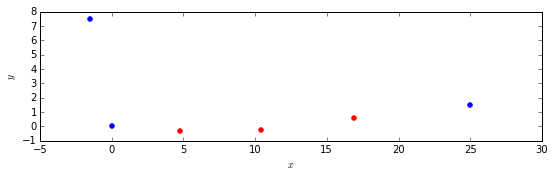

In [261]:
fig = plt.figure(figsize=(9,9))

ax = fig.gca(aspect='equal')
ax.scatter(gammaF.real, gammaF.imag, color='b')
ax.scatter(gammaL.real, gammaL.imag, color='r')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [262]:
g = G(indexFreeNode, indexFixedNode, gammaF, CL, CF, rng_activeBendingRod)

In [263]:
g([[-0.67561189, -0.31634141,  0.12285089]])

v = [-0.67561189 -0.31634141  0.12285089  0.26285   ]
(-2.5-0.67561189j)
(-2-0.31634141j)
(-1.5+0.12285089j)
(-1+0.26285j)
Elastica Rod 0
***************
Element 0
 dAB =   4.7236         lcrit =  20.0852 m
   R = -11.8089 kN          S =  -3.1913 kN
  MA =   0.0000            MB =  15.0743
 muA =   0.0000           muB =   0.0614
kmin = 0.09638
flag = 0
k = 0.14411,    H/|P| = -0.95846

beta = -0.36429    alpha = -0.26394
phiA = -0.38958    phiB = -0.31505
Element 1
 dAB =   5.7822         lcrit =  20.5300 m
   R = -11.5644 kN          S =  -1.8292 kN
  MA =  15.0743            MB =  25.6509
 muA =   0.0627           muB =   0.1067
kmin = 0.16763
flag = 0
k = 0.16793,    H/|P| = -0.94360

beta = -0.19881    alpha = -0.15687
phiA = -0.31478    phiB = -0.06208
Element 2
 dAB =   7.0860         lcrit =  21.5111 m
   R = -10.6290 kN          S =   0.8705 kN
  MA =  25.6509            MB =  19.4825
 muA =   0.1118           muB =   0.0849
kmin = 0.17564
flag = 0
flag = 1
k = 0.17564,    lm

array([-0.00026606, -0.00049294,  0.00209716])

beta = -0.36429    alpha = -0.26394
phiA = -0.38958    phiB = -0.31505
beta = -0.19881    alpha = -0.15687
phiA = -0.31478    phiB = -0.06208
beta = 0.12283    alpha = 0.08172
phiA = -0.06159    phiB = 0.29228
beta = 0.41314    alpha = 0.25704
phiA = 0.29018    phiB = 0.47878


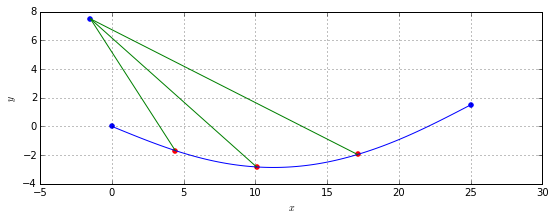

In [264]:
g.plot()

In [265]:
x0 = [[-0.64511629, -0.30982594,  0.10766722]]
sol = scipy.optimize.broyden1(g, x0)

v = [-0.64511629 -0.30982594  0.10766722  0.26285   ]
(-2.5-0.64511629j)
(-2-0.30982594j)
(-1.5+0.10766722j)
(-1+0.26285j)
Elastica Rod 0
***************
Element 0
 dAB =   4.7305         lcrit =  20.1008 m
   R = -11.8262 kN          S =  -3.0517 kN
  MA =   0.0000            MB =  14.4359
 muA =   0.0000           muB =   0.0588
kmin = 0.09237
flag = 0
k = 0.13796,    H/|P| = -0.96194

beta = -0.35201    alpha = -0.25254
phiA = -0.37627    phiB = -0.30478
Element 1
 dAB =   5.7751         lcrit =  20.5479 m
   R = -11.5501 kN          S =  -1.7893 kN
  MA =  14.4359            MB =  24.7691
 muA =   0.0601           muB =   0.1031
kmin = 0.16200
flag = 0
k = 0.16238,    H/|P| = -0.94726

beta = -0.19498    alpha = -0.15369
phiA = -0.30628    phiB = -0.06343
Element 2
 dAB =   7.0768         lcrit =  21.5334 m
   R = -10.6152 kN          S =   0.7619 kN
  MA =  24.7691            MB =  19.3770
 muA =   0.1081           muB =   0.0846
kmin = 0.16977
flag = 0
flag = 1
k = 0.16977,    lm

beta = -0.36253    alpha = -0.26231
phiA = -0.38766    phiB = -0.31357
beta = -0.19826    alpha = -0.15643
phiA = -0.31357    phiB = -0.06228
beta = 0.12142    alpha = 0.08025
phiA = -0.06228    phiB = 0.29040
beta = 0.41323    alpha = 0.25704
phiA = 0.29040    phiB = 0.47882


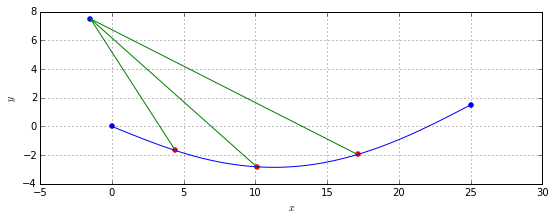

In [266]:
g.plot()